## Data exploration

In [ ]:
fake_path = '/content/drive/MyDrive/Data255_Project_Dataset/train/Fake_Faces'
real_path = '/content/drive/MyDrive/Data255_Project_Dataset/train/Real_Faces'
fake_list = os.listdir(fake_path)
real_list = os.listdir(real_path)

In [ ]:
def plot_instances(n_rows, n_cols, path, set_title=False, title='', figure_size=(10, 8)):
  fig, axs = plt.subplots(n_rows, n_cols, figsize=figure_size)
  for i, ax in enumerate(axs.flat):
    ax.imshow(load_img(path +'/' +os.listdir(path)[i+60]))
    ax.set_axis_off()
  if set_title:
    plt.suptitle(title, fontsize=16)

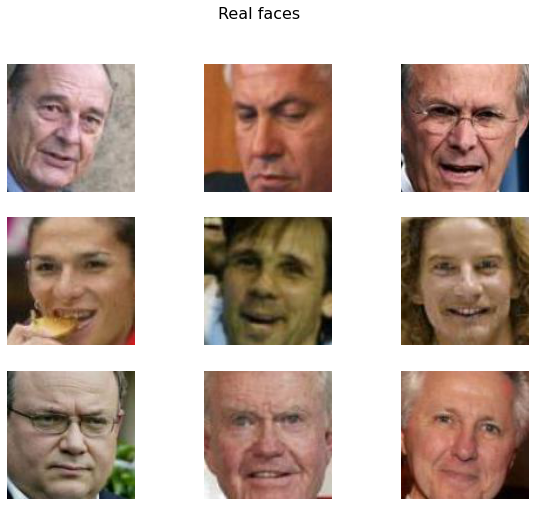

In [ ]:
plot_instances(3, 3, real_path, set_title=True, title='Real faces')

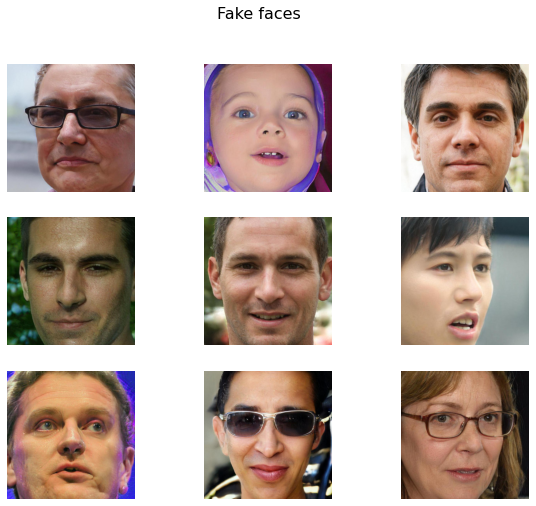

In [ ]:
plot_instances(3, 3, fake_path, set_title=True, title='Fake faces')

### Data Processing

In [ ]:
#@title
import numpy as np
import pandas as pd

import os

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import MobileNetV2
from keras.layers import Conv2D, Dense, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten
from keras.optimizers import Adam
import splitfolders

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
! pip install split-folders
import splitfolders
splitfolders.ratio(path, output=output_path, ratio=(0.8, 0.1, 0.1), group_prefix=None)

Copying files: 20000 files [04:52, 68.40 files/s]


In [ ]:
train_path = '/content/drive/MyDrive/Data255_Project_Dataset/train'

data_gen = ImageDataGenerator(rescale=1./255)

training_set = data_gen.flow_from_directory(train_path,
                                            class_mode='binary',
                                            shuffle=True,
                                            target_size=(96,96),
                                            batch_size=64,
                                           )

training_set.class_indices

In [ ]:
valid_path = '/content/drive/MyDrive/Data255_Project_Dataset/val'

valid_set = data_gen.flow_from_directory(valid_path,
                                         class_mode='binary',
                                         shuffle=True,
                                         target_size=(96,96),
                                         batch_size=64
                                         )

valid_set.class_indices

In [ ]:
test_path = '/content/drive/MyDrive/Data255_Project_Dataset/test'

test_set = data_gen.flow_from_directory(test_path,
                                        class_mode='binary',
                                        target_size=(96,96),
                                        batch_size=64
                                       )

test_set.class_indices

## Solution Implementation and Evaluation

### CNN with 3 Convolutional Layers

In [ ]:
model = Sequential()

model.add(Conv2D(32,(3,3),input_shape = (200,200,3), activation = 'relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 128)      

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = model.fit(train_generator,
                              validation_data = validation_generator,
                              epochs = 30, callbacks=[es])

Epoch 1/30
250/250 [==============================] - 3672s 15s/step - loss: 0.5519 - accuracy: 0.7586 - val_loss: 0.1163 - val_accuracy: 0.9582
Epoch 2/30
250/250 [==============================] - 120s 479ms/step - loss: 0.1140 - accuracy: 0.9567 - val_loss: 0.0891 - val_accuracy: 0.9615
Epoch 3/30
250/250 [==============================] - 118s 472ms/step - loss: 0.0931 - accuracy: 0.9657 - val_loss: 0.0651 - val_accuracy: 0.9728
Epoch 4/30
250/250 [==============================] - 118s 471ms/step - loss: 0.0542 - accuracy: 0.9792 - val_loss: 0.0484 - val_accuracy: 0.9810
Epoch 5/30
250/250 [==============================] - 117s 469ms/step - loss: 0.0437 - accuracy: 0.9840 - val_loss: 0.0812 - val_accuracy: 0.9675
Epoch 6/30
250/250 [==============================] - 117s 470ms/step - loss: 0.0487 - accuracy: 0.9796 - val_loss: 0.0541 - val_accuracy: 0.9810
Epoch 7/30
250/250 [==============================] - 117s 469ms/step - loss: 0.0371 - accuracy: 0.9865 - val_loss: 0.0500 - 

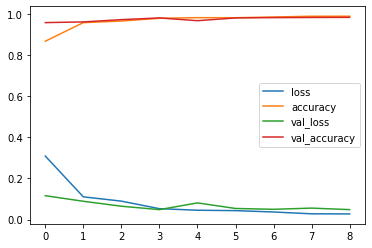

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(history.history, columns=history.history.keys())
plt.plot(df)
plt.legend(history.history.keys())
plt.show()

#### Evaluate

In [ ]:
y_true = validation_generator.classes
y_true

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
Y_pred = model.predict(validation_generator)
y_pred = (Y_pred > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

conf = pd.DataFrame(confusion_matrix(y_true, y_pred), index=['True[0]', 'True[1]'], columns=['Pred[0]', 'Pred[1]'])

print(classification_report(y_true, y_pred))
conf

              precision    recall  f1-score   support

           0       0.93      0.86      0.90      1000
           1       0.87      0.94      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



,Pred[0],Pred[1]
True[0],861,139
True[1],62,938


### MobileNetV2

In [ ]:
mobilenet = MobileNetV2(input_shape=(96, 96, 3),
                        include_top=False,
                        weights='imagenet'
                       )

model = tf.keras.models.Sequential([mobilenet,
                                    GlobalAveragePooling2D(),
                                    Dense(128, activation='relu'),
                                    BatchNormalization(),
                                    Dropout(0.3),
                                    Dense(1, activation='sigmoid')
                                   ])
model.compile(optimizer=Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = model.fit(x=training_set, epochs=20, validation_data=valid_set, callbacks=[callback], verbose=2)

##### Evaluate

In [ ]:
y_true = test_set.classes
y_pred = model.predict(test_set)
y_pred = y_pred.astype('int').reshape(-1)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

### MobileNetV2 Subtraction

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = model.fit(x=valid_set, epochs=2, verbose=2)

Epoch 1/2
32/32 - 11s - loss: 0.0263 - accuracy: 0.9935
Epoch 2/2
32/32 - 11s - loss: 0.0197 - accuracy: 0.9945


##### Evaluate

In [ ]:
y_pred = model.predict(test_set)
y_pred_int = y_pred.astype('int').reshape(-1)

In [ ]:
print(confusion_matrix(y_true, y_pred_int))
print(classification_report(y_true, y_pred_int))

[[974  26]
 [ 38 962]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1000
           1       0.97      0.96      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

